# Sediment resuspension --- regions of importance

In [1]:
import os
os.environ['PROJ_LIB'] = '/home/brogalla/anaconda3/share/proj'

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import csv
from mpl_toolkits.basemap import Basemap, cm
import netCDF4 as nc
import cmocean
import glob
import pandas as pd 
from matplotlib.patches import ConnectionPatch
import matplotlib as mpl
import pandas as pd
import matplotlib.animation as animation
from matplotlib import rc
import warnings
warnings.filterwarnings('ignore')
import pickle

%matplotlib notebook

In [4]:
import sys
sys.path.insert(0, '/ocean/brogalla/GEOTRACES/analysis-brogalla/modules')
import ariane as ar

In [4]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


#### Load model bathymetry

In [5]:
land_color = "#8b7765"

# load bathymetry file:
mesh     = nc.Dataset('/ocean/brogalla/GEOTRACES/analysis-birgit/notebooks/ANHA12/ANHA12_mesh1.nc')
mesh_lon = mesh.variables['nav_lon']
mesh_lat = mesh.variables['nav_lat']
mesh_bathy = mesh.variables['hdept'][0]
mesh_lon   = np.array(mesh_lon)
mesh_lat   = np.array(mesh_lat)
mesh_bathy = np.array(mesh_bathy)
tmask      = np.array(mesh.variables['tmask'][0,:,:,:])
Z_masked   = np.ma.masked_where((tmask > 0.1), tmask) 
e3t0       = np.array(mesh.variables['e3t_0'])
nav_lev    = np.array(mesh.variables['nav_lev'])

In [6]:
c = nc.Dataset('/data/brogalla/run_storage/reference/ANHA12_EXH006_2002_monthly.nc', 'r')

# Load structure from sample dataset:
lat_model = c.variables['nav_lat']
lon_model = c.variables['nav_lon']
depths_model = c.variables['deptht']
lat_model = np.array(lat_model)
lon_model = np.array(lon_model)
depths_model = np.array(depths_model)

In [7]:
bathy      = mesh_bathy[1480:2050,160:800]
flux       = 8.0e-9  # g/m2/s

In [8]:
importance = np.zeros_like(bathy)
sediment   = np.zeros_like(bathy)

for i in range(0,570):
    for j in range(0, 640):
        importance[i,j] = np.exp(-0.5*(bathy[i,j]-400)**2/(200**2))
        for z in range(0,50):
            if (bathy[i,j] <= nav_lev[z] and bathy[i,j] >= nav_lev[z-1]):
                zbottom = e3t0[0,z,1480+i,160+j]                
                sediment[i,j] = importance[i,j] / zbottom

In [9]:
c           = nc.Dataset('/ocean/brogalla/GEOTRACES/data/resuspension_rate-20190924.nc','r')
resus_class = np.array(c.variables['dmn_resus'])[1480:2050, 160:800]

<IPython.core.display.Javascript object>


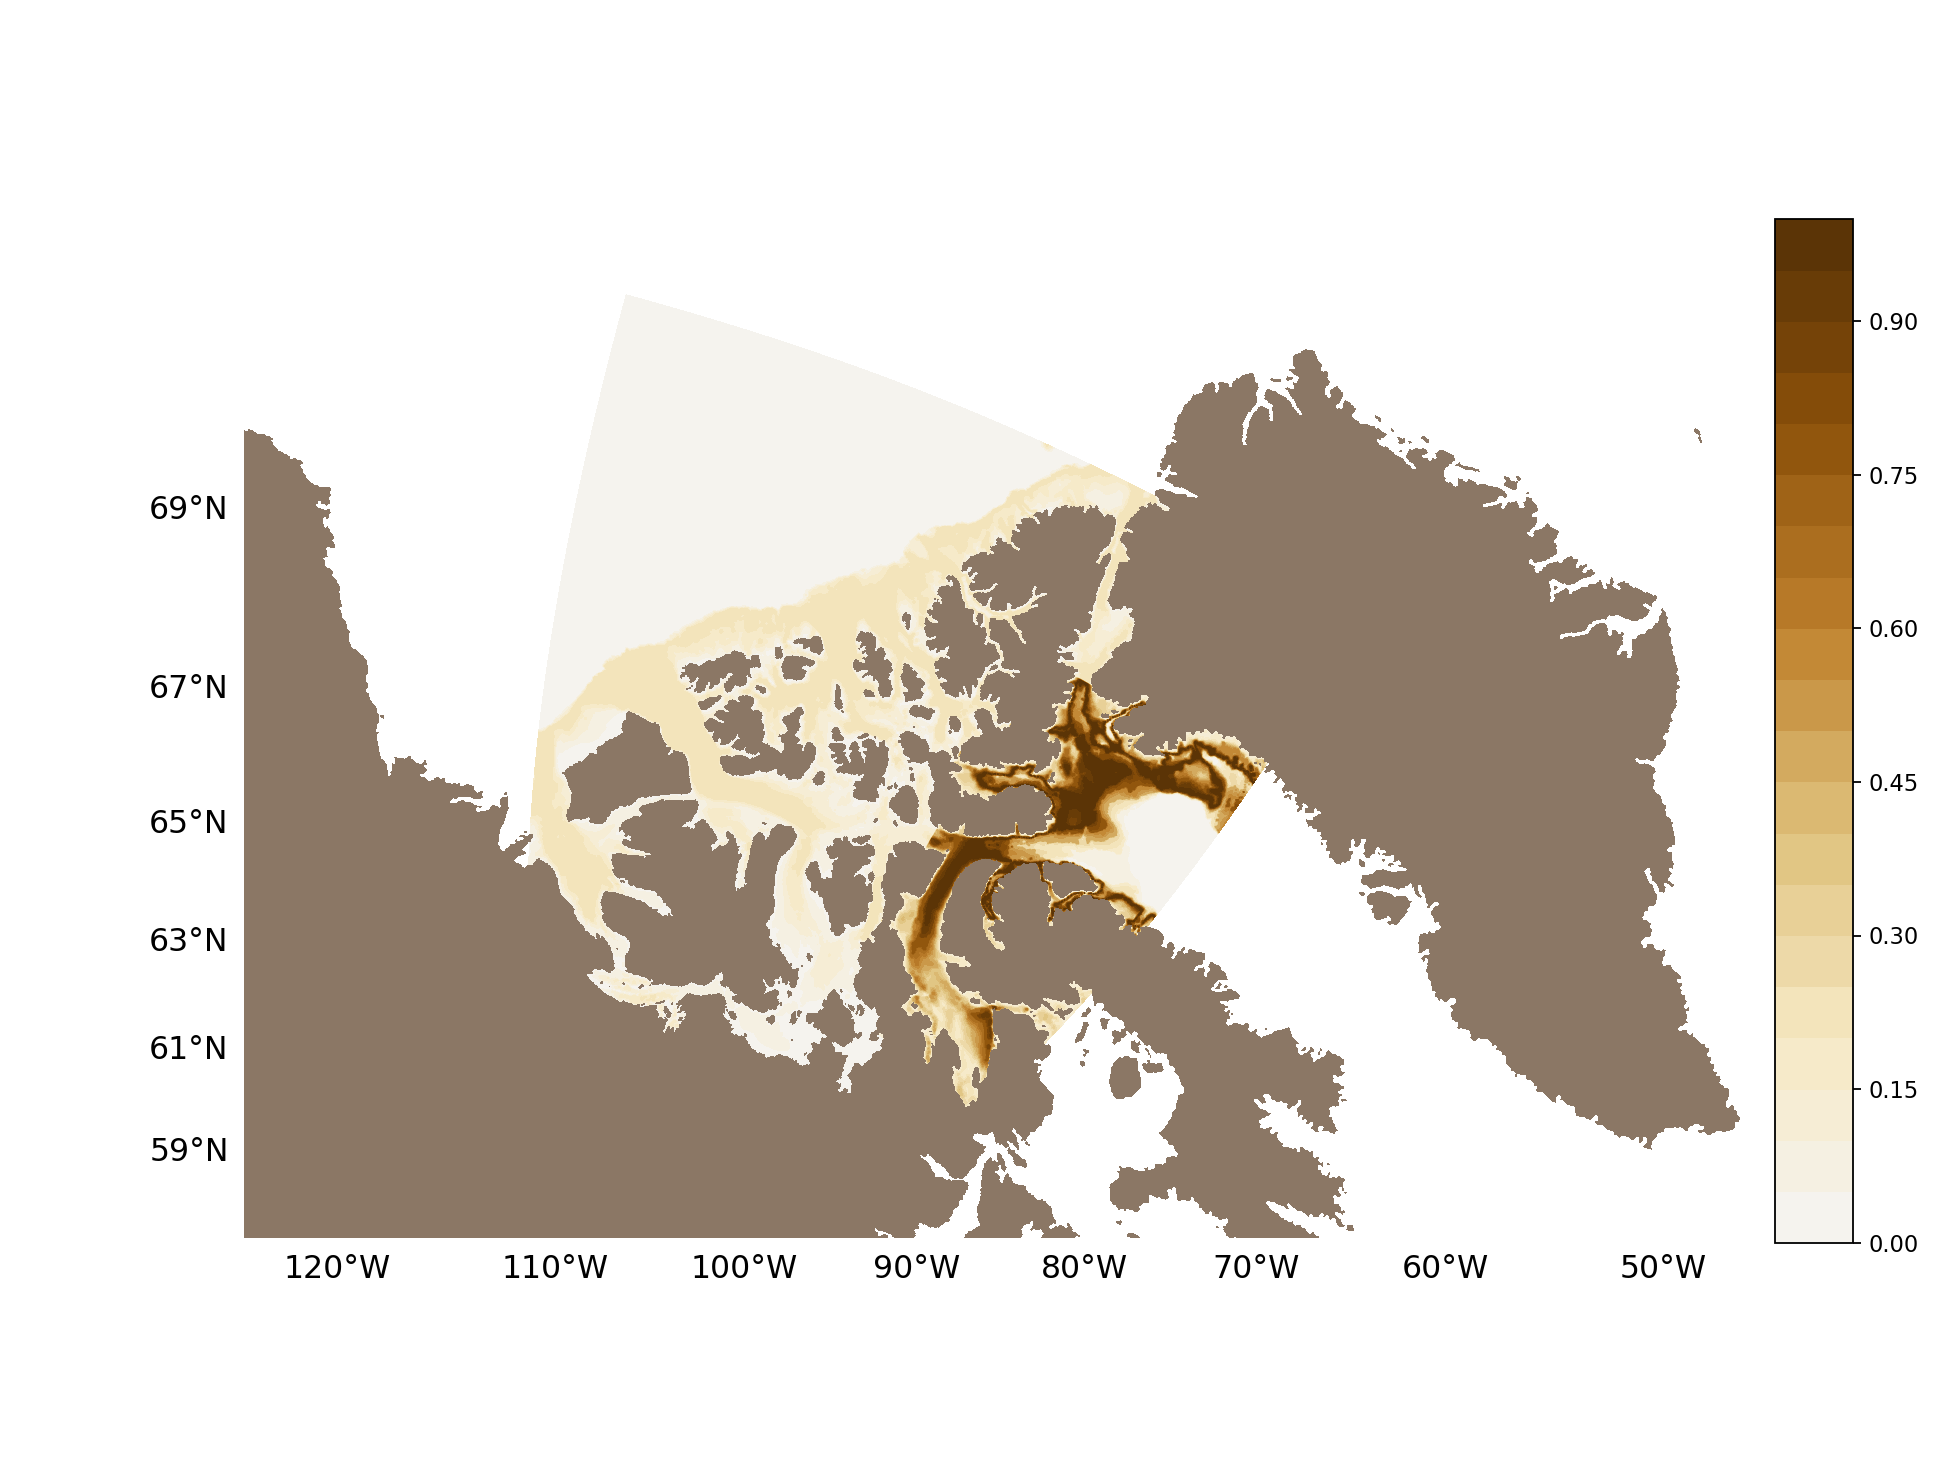

In [41]:
fig, ax1, proj1 = pickle.load(open('/ocean/brogalla/GEOTRACES/analysis-brogalla/maps/mn-reference.pickle','rb'))
#-----------------------------------------------------------------------------

x, y = proj1(lon_model, lat_model)

cbar = proj1.contourf(x, y, importance*resus_class, 20, vmin=-1.0, vmax=1.0, cmap=plt.get_cmap('BrBG_r'))

x_stn, y_stn = proj1([lon_model[104,370], lon_model[100,365], lon_model[91,353],  lon_model[175,311], \
                      lon_model[175,326], lon_model[233,313], lon_model[214,281], lon_model[352,281], \
                      lon_model[242,364], lon_model[458,332], lon_model[508,384], lon_model[547,457]], \
                     [lat_model[104,370], lat_model[100,365], lat_model[91,353],  lat_model[175,311], \
                      lat_model[175,326], lat_model[233,313], lat_model[214,281], lat_model[352,281], \
                      lat_model[242,364], lat_model[458,332], lat_model[508,384], lat_model[547,457]])

# proj1.plot(x_stn, y_stn, '*w', markersize=10)

cbar_ax = fig.add_axes([0.91, 0.15, 0.04, 0.7])
c_bar = fig.colorbar(cbar, cax=cbar_ax)

fig.savefig('/ocean/brogalla/GEOTRACES/figures/sediment-resuspension-regions.png', bbox_inches='tight', dpi=300)